Demo for deskewing and using pyclesperanto and its affinetranform3d class

In [4]:
import napari
from aicsimageio import AICSImage
import pyclesperanto_prototype as cle
import numpy as np

#decimal places when printing floats is set to 3
np.set_printoptions(3)

In [5]:
img_path = "..\sample_data\RBC_tiny.czi"

rbc_aics = AICSImage(img_path)

voxel_size_x = rbc_aics.physical_pixel_sizes.X
voxel_size_y = rbc_aics.physical_pixel_sizes.Y
voxel_size_z = rbc_aics.physical_pixel_sizes.Z


rbc = rbc_aics.dask_data[0,0,...]

print("Shape",rbc.shape)



Shape (834, 118, 209)


Max X projection


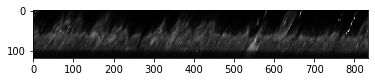

In [6]:
print("Max X projection")
cle.imshow(cle.maximum_x_projection(rbc))

Deskewing is implemented as a series of transformations in pyclesperanto. 

cle.AffineTransform3D is a class to setup and work with affine transform matrices

In [7]:
#initialise a transform
shear_transform =cle.AffineTransform3D()
#To access the matrix you call the ._matrix method
shear_transform._matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

The deskew_y function calls the function here:
https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier8/_deskew_y.py

which in turn uses the transform defined here:

https://github.com/clEsperanto/pyclesperanto_prototype/blob/50a1f3ae6387963019c6997c69f239fb81adc4dc/pyclesperanto_prototype/_tier8/_AffineTransform3D.py#L301

* Shear in XZ plane along Y axis around 90-deskew_angle
* Coverslip rotation 
* Scale the image
* Rotate it 90 degrees around X so that the Z plane is prox to distal

Biggest point to keep in mind is the transforms in Clesperanto are all for images in the XYZ order. You pass the images as a ZYX array to clesperanto. AS it usees OpenCL, images are processed in the XYZ format, hence affine transforms are in the XYZ format. 

However, gputools and other libraries in python use affine transforms in ZYX format. This is the biggest difference to keep in mind.

In [8]:
print("Before shearing")
print(shear_transform._matrix)

Before shearing
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [9]:
#To apply a transform, you call the associated methods in the AffineTransform3D class
#Shear in X plane:
deskewing_angle = 30
shear_transform.shear_in_x_plane(angle_y_in_degrees = 90 - deskewing_angle)

print("After shearing in X plane")
print(shear_transform._matrix)

print("Note that the matrix is different from above as we applied shearing")

After shearing in X plane
[[1.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.000e+00 1.732e+00 0.000e+00]
 [0.000e+00 6.123e-17 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00]]
Note that the matrix is different from above as we applied shearing


Once you've defined a transformation, to apply it, you use:
`affine_transform` method

(834, 1562, 209)
After shearing


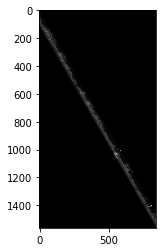

In [10]:
#Auto size is the speial method that determines if the image is out of bounds and if so, moves it back in bounds
shear_transformed = cle.affine_transform(source= rbc,transform = shear_transform,auto_size=True)
print(shear_transformed.shape)
print("After shearing")
cle.imshow(cle.maximum_x_projection(shear_transformed))


Implementation for deskewing below. 

In [11]:
#Defining Deskewing
deskewing_angle = 30
scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
   
deskew_transform.shear_in_x_plane(angle_y_in_degrees = 90 - deskewing_angle)

# rotate the stack to get proper Z-planes; rotate 90 - angle around X-axis
deskew_transform.rotate(angle_in_degrees = 90 - deskewing_angle, axis=0)

#This calculation has been lifted from tlamberts and Volkers code
# make voxels isotropic, calculate the new scaling factor for Z after shearing
# https://github.com/tlambert03/napari-ndtiffs/blob/092acbd92bfdbf3ecb1eb9c7fc146411ad9e6aae/napari_ndtiffs/affine.py#L57
import math
new_dz = math.sin(deskewing_angle * math.pi / 180.0) * voxel_size_z
scale_factor_z = (new_dz / voxel_size_y) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)

# correct orientation so that the new Z-plane goes proximal-distal from the objective.
deskew_transform.rotate(angle_in_degrees=90, axis=0)

print("Affine transformation for deskewing")
print(deskew_transform._matrix)


Affine transformation for deskewing
[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -8.959e-01 -2.069e+00  0.000e+00]
 [ 0.000e+00  5.000e-01  4.598e-16  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


Once you've defined a transformation, to apply it, you use:
`affine_transform` method

In [12]:
#Auto size is the special method that determines if the image is out of bounds and if so, moves it back in
deskewed = cle.affine_transform(source= rbc,transform = deskew_transform,auto_size=True)
print(deskewed.shape)


(59, 1831, 209)


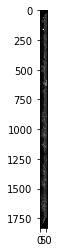

In [13]:
cle.imshow(cle.maximum_x_projection(deskewed))

In [ ]:
import napari 
viewer = napari.Viewer()
viewer.add_image(rbc)
viewer.add_image(deskewed)